In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty50-candle-data/NIFTY__1m.txt
/kaggle/input/nifty50-candle-data/NIFTY__1m_orig.txt
/kaggle/input/nifty50-candle-data/NIFTY__30m.txt
/kaggle/input/nifty50-candle-data/note.txt
/kaggle/input/nifty50-candle-data/NIFTY__1h.txt
/kaggle/input/nifty50-candle-data/NIFTY__4h.txt
/kaggle/input/nifty50-candle-data/NIFTY__1d.txt


In [34]:
from typing import *


Loading candlesticks

In [35]:
from dataclasses import dataclass
from datetime import datetime
import pandas

@dataclass
class CandleStick:
    open: float
    high: float
    low: float
    close: float
    volume: float
    timestamp: pandas.Timestamp

    def __str__(self):
        return f"{self.open},{self.high},{self.low},{self.close},{self.volume},{self.timestamp}"

# Find smaller time frame candle in larger time frame
def findCandleIndex(largerCandles: list[CandleStick], smallCandle: CandleStick) -> int: 
    for i in range(len(largerCandles) - 1, -1, -1):
        if smallCandle.timestamp.date() > largerCandles[i].timestamp.date():
            return i       
    return None

def readCandles(fileName: str) -> list[CandleStick]:
    candles = []
    lines = open(fileName, "r").readlines()
    
    for line in lines:
        data = line.split(",")
        candles.append(CandleStick(float(data[0]), float(data[1]), float(data[2]), float(data[3]), float(data[4]), pandas.Timestamp(data[5])))
    
    return candles

def readCandlesToDataFrame(fileName: str) -> pd.DataFrame:
    df = pd.read_csv(fileName, delimiter=',', header=None, names=['Open', 'High', 'Low', 'Close', 'Volume','Date'])
    df.drop(columns=['Volume'], inplace=True)
    df = df.set_index('Date', inplace=False)

    return df

In [36]:
daily_data_path = '/kaggle/input/nifty50-candle-data/NIFTY__1d.txt'

In [37]:
daily_data = readCandlesToDataFrame(daily_data_path)

In [38]:
def calculateLogReturns(data: pd.DataFrame)->pd.DataFrame:
    # Assumes data has Close column
    df = data.copy()
    df['LogReturns'] = np.log(df['Close']/df['Close'].shift(1))
    # df.dropna(inplace=True)

    return df

In [39]:
daily_data = calculateLogReturns(daily_data)

AIC-BIC criteria for Gaussian Mixtures

In [40]:
daily_data.dropna(inplace=True)
daily_data

,Open,High,Low,Close,LogReturns
Date,,,,,
2015-01-12 09:15:00,8291.35,8332.25,8245.60,8326.55,0.005576
2015-01-13 09:15:00,8346.15,8356.65,8268.15,8303.80,-0.002736
2015-01-14 09:15:00,8307.25,8326.30,8236.75,8287.75,-0.001935
2015-01-15 09:15:00,8425.20,8526.90,8380.75,8461.15,0.020707
2015-01-19 09:15:00,8467.45,8570.80,8459.35,8550.30,0.010481
...,...,...,...,...,...
2024-10-31 09:15:00,24349.85,24372.45,24172.60,24238.50,-0.004602
2024-11-04 09:15:00,24315.75,24316.75,23816.15,23990.95,-0.010266
2024-11-05 09:15:00,23916.50,24229.05,23842.75,24198.15,0.008600


In [41]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import seaborn as sns

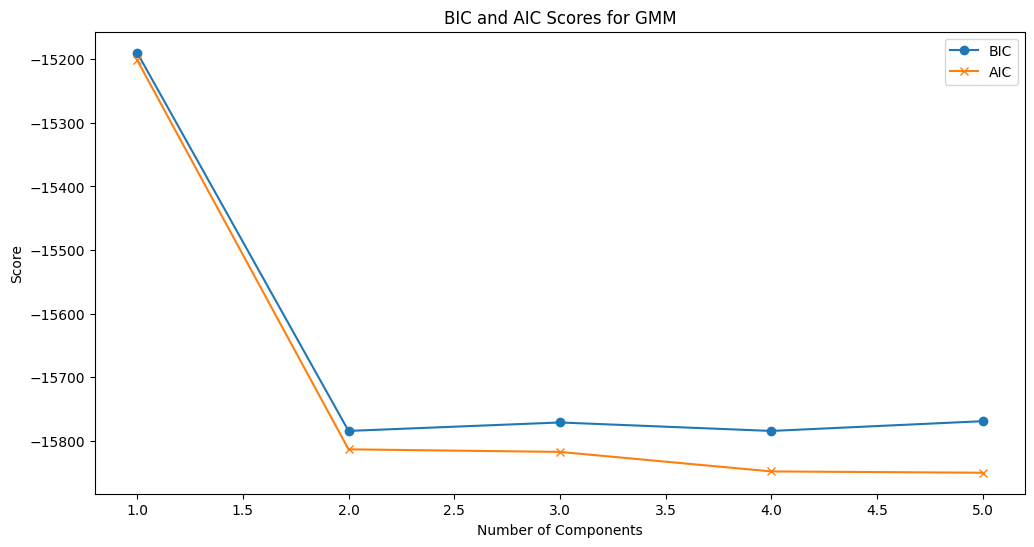

In [42]:
log_ret_data = daily_data['LogReturns'].values.reshape(-1,1)

aic = []
bic = []

k_arr = [1,2,3,4,5]

models = {}

for k in k_arr:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(log_ret_data)

    aic.append(gmm.aic(log_ret_data))
    bic.append(gmm.bic(log_ret_data))

    models[k] = gmm

plt.figure(figsize=(12, 6))
plt.plot(k_arr, bic, label='BIC', marker='o')
plt.plot(k_arr, aic, label='AIC', marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM')
plt.show()



Best number of components (based on BIC): 4


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


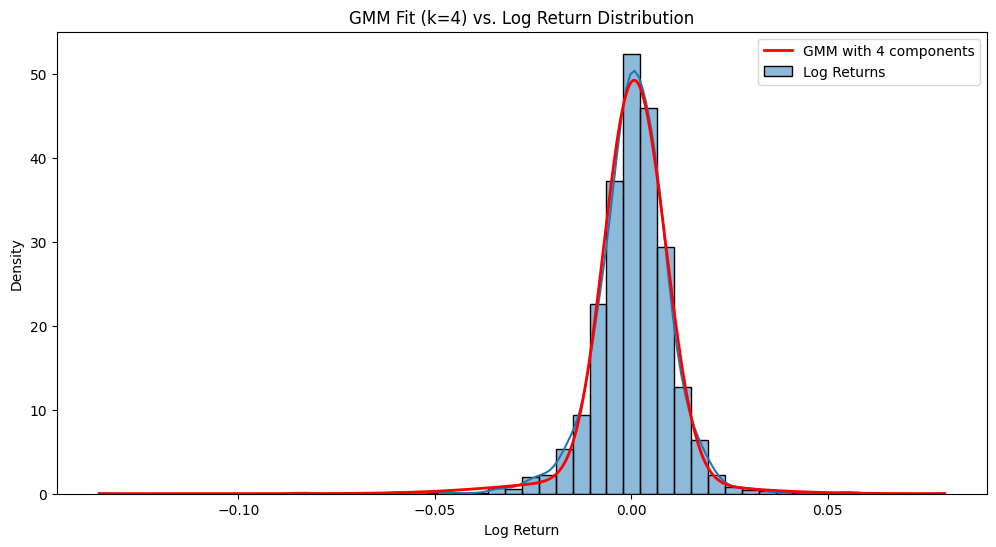

In [43]:
best_k = k_arr[np.argmin(bic)]  # Choose the model with the lowest BIC
print(f"Best number of components (based on BIC): {best_k}")

# Fit the best GMM model
best_gmm = models[best_k - 1]

# Visualize the fitted GMM density
x = np.linspace(log_ret_data.min(), log_ret_data.max(), 1000).reshape(-1, 1)
log_prob = best_gmm.score_samples(x)
pdf = np.exp(log_prob)

# Plot the histogram and the GMM density
plt.figure(figsize=(12, 6))
sns.histplot(log_ret_data, bins=50, kde=True, stat='density', label='Log Returns', color='lightblue')
plt.plot(x, pdf, label=f'GMM with {best_k} components', color='red', linewidth=2)
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.title(f'GMM Fit (k={best_k}) vs. Log Return Distribution')
plt.show()

In [44]:
print(bic[3])

-15784.664386757377


Gaussian-Laplace

In [45]:
import numpy as np
from scipy.stats import norm, laplace, ks_2samp
from scipy.optimize import minimize

class GaussianLaplaceMixture:
    def __init__(self, n_components=2):
        """
        Initialize Gaussian-Laplace mixture model.
        
        Parameters:
        n_components (int): Number of components in the mixture
        """
        self.n_components = n_components
        self.weights = np.ones(n_components) / n_components
        self.means = None
        self.scales = None
        self.component_types = None
        self.n_parameters = None  # Total number of free parameters
        
    def _initialize_parameters(self, X):
        """Initialize model parameters based on data"""
        self.means = np.random.uniform(np.min(X), np.max(X), self.n_components)
        self.scales = np.ones(self.n_components) * np.std(X)
        self.component_types = np.random.choice([True, False], size=self.n_components)
        
        # Calculate number of free parameters
        # For each component: 1 weight (minus 1 for constraint), 1 mean, 1 scale
        self.n_parameters = (self.n_components - 1) + 2 * self.n_components
        
    def _component_pdf(self, X, mean, scale, is_gaussian):
        """Calculate PDF for a single component"""
        if is_gaussian:
            return norm.pdf(X.ravel(), mean, scale)
        else:
            return laplace.pdf(X.ravel(), mean, scale)
    
    def _log_likelihood(self, X):
        """Calculate log likelihood of the data"""
        n_samples = len(X)
        ll = np.zeros(n_samples)
        
        for i in range(self.n_components):
            component_ll = self._component_pdf(X, self.means[i], self.scales[i], 
                                            self.component_types[i])
            ll += self.weights[i] * component_ll
            
        return np.sum(np.log(ll))
    
    def _e_step(self, X):
        """Expectation step: calculate responsibilities"""
        n_samples = len(X)
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * self._component_pdf(
                X, self.means[i], self.scales[i], self.component_types[i]
            )
            
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        X_flat = X.ravel()
        n_samples = len(X_flat)
        
        self.weights = responsibilities.sum(axis=0) / n_samples
        
        for i in range(self.n_components):
            resp_i = responsibilities[:, i]
            resp_sum = resp_i.sum()
            
            self.means[i] = np.sum(resp_i * X_flat) / resp_sum
            
            if self.component_types[i]:  # Gaussian
                self.scales[i] = np.sqrt(np.sum(
                    resp_i * (X_flat - self.means[i])**2) / resp_sum)
            else:  # Laplace
                self.scales[i] = np.sum(
                    resp_i * np.abs(X_flat - self.means[i])) / resp_sum
    
    def pdf(self, X):
        """Calculate PDF for the mixture model"""
        X = np.asarray(X)
        pdf_values = np.zeros(len(X.ravel()))
        
        for i in range(self.n_components):
            pdf_values += self.weights[i] * self._component_pdf(
                X, self.means[i], self.scales[i], self.component_types[i]
            )
            
        return pdf_values
    
    def cdf(self, X):
        """Calculate CDF for the mixture model"""
        X = np.asarray(X)
        cdf_values = np.zeros(len(X.ravel()))
        
        for i in range(self.n_components):
            if self.component_types[i]:  # Gaussian
                component_cdf = norm.cdf(X.ravel(), self.means[i], self.scales[i])
            else:  # Laplace
                component_cdf = laplace.cdf(X.ravel(), self.means[i], self.scales[i])
            cdf_values += self.weights[i] * component_cdf
            
        return cdf_values
    
    def fit(self, X, max_iter=100, tol=1e-4):
        """Fit the model to data using EM algorithm."""
        X = np.asarray(X)
        if X.ndim > 2:
            raise ValueError("Input array must be 1D or 2D")
        if X.ndim == 2 and X.shape[1] != 1:
            raise ValueError("For 2D input, second dimension must be 1")
            
        self._initialize_parameters(X.ravel())
        
        prev_ll = -np.inf
        
        for _ in range(max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            
            current_ll = self._log_likelihood(X)
            if abs(current_ll - prev_ll) < tol:
                break
            prev_ll = current_ll
    
    def compute_metrics(self, X):
        """
        Compute various goodness-of-fit metrics.
        
        Returns:
        dict: Dictionary containing various metrics
            - AIC: Akaike Information Criterion
            - BIC: Bayesian Information Criterion
            - MSE: Mean Squared Error of PDF
            - KS: Kolmogorov-Smirnov test statistic and p-value
        """
        X = np.asarray(X).ravel()
        n_samples = len(X)
        
        # Log-likelihood
        ll = self._log_likelihood(X)
        
        # AIC and BIC
        aic = -2 * ll + 2 * self.n_parameters
        bic = -2 * ll + np.log(n_samples) * self.n_parameters
        
        # Generate points for PDF comparison
        x_range = np.linspace(np.min(X), np.max(X), 1000)
        hist, bin_edges = np.histogram(X, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        pdf_values = self.pdf(bin_centers)
        
        # MSE of PDF
        mse = np.mean((hist - pdf_values) ** 2)
        
        # Kolmogorov-Smirnov test
        # Generate samples from fitted distribution
        samples = self.sample(n_samples)
        ks_stat, ks_pvalue = ks_2samp(X, samples)
        
        metrics = {
            'aic': aic,
            'bic': bic,
            'mse': mse,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pvalue
        }
        
        return metrics
    
    def predict_proba(self, X):
        """Predict probability of each component for data points"""
        X = np.asarray(X)
        if X.ndim == 2 and X.shape[1] != 1:
            raise ValueError("For 2D input, second dimension must be 1")
        return self._e_step(X)
    
    def sample(self, n_samples):
        """Generate random samples from the mixture model"""
        samples = []
        component_choices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )
        
        for i in range(self.n_components):
            mask = component_choices == i
            n_component_samples = np.sum(mask)
            
            if n_component_samples > 0:
                if self.component_types[i]:  # Gaussian
                    component_samples = np.random.normal(
                        self.means[i], self.scales[i], n_component_samples
                    )
                else:  # Laplace
                    component_samples = np.random.laplace(
                        self.means[i], self.scales[i], n_component_samples
                    )
                samples.append(component_samples)
        
        return np.concatenate(samples)

In [46]:
model = GaussianLaplaceMixture(n_components=2)
model.fit(log_ret_data.reshape(-1,1))

In [47]:
metrics = model.compute_metrics(log_ret_data)

# Print results
print(f"AIC: {metrics['aic']:.4f}")
print(f"BIC: {metrics['bic']:.4f}")
print(f"MSE: {metrics['mse']:.6f}")
print(f"KS statistic: {metrics['ks_statistic']:.4f}")
print(f"KS p-value: {metrics['ks_pvalue']:.4f}")

AIC: -15856.0124
BIC: -15827.0507
MSE: 0.349532
KS statistic: 0.0136
KS p-value: 0.9782


In [48]:
model = GaussianLaplaceMixture(n_components=3)
model.fit(log_ret_data.reshape(-1,1))

metrics = model.compute_metrics(log_ret_data)

# Print results
print(f"AIC: {metrics['aic']:.4f}")
print(f"BIC: {metrics['bic']:.4f}")
print(f"MSE: {metrics['mse']:.6f}")
print(f"KS statistic: {metrics['ks_statistic']:.4f}")
print(f"KS p-value: {metrics['ks_pvalue']:.4f}")

AIC: -15865.5814
BIC: -15819.2426
MSE: 0.349122
KS statistic: 0.0198
KS p-value: 0.7285


In [49]:
model = GaussianLaplaceMixture(n_components=4)
model.fit(log_ret_data.reshape(-1,1))

metrics = model.compute_metrics(log_ret_data)

# Print results
print(f"AIC: {metrics['aic']:.4f}")
print(f"BIC: {metrics['bic']:.4f}")
print(f"MSE: {metrics['mse']:.6f}")
print(f"KS statistic: {metrics['ks_statistic']:.4f}")
print(f"KS p-value: {metrics['ks_pvalue']:.4f}")

AIC: -15855.0387
BIC: -15791.3228
MSE: 1.017691
KS statistic: 0.0376
KS p-value: 0.0655


In [50]:
model = GaussianLaplaceMixture(n_components=1)
model.fit(log_ret_data.reshape(-1,1))

metrics = model.compute_metrics(log_ret_data)

# Print results
print(f"AIC: {metrics['aic']:.4f}")
print(f"BIC: {metrics['bic']:.4f}")
print(f"MSE: {metrics['mse']:.6f}")
print(f"KS statistic: {metrics['ks_statistic']:.4f}")
print(f"KS p-value: {metrics['ks_pvalue']:.4f}")

AIC: -15769.9913
BIC: -15758.4066
MSE: 6.574387
KS statistic: 0.0297
KS p-value: 0.2349


In [51]:
import numpy as np
from scipy.stats import norm, cauchy
from scipy.optimize import minimize

class GaussianCauchyMixture:
    def __init__(self, n_components=2):
        """
        Initialize Gaussian-Cauchy mixture model.
        
        Parameters:
        n_components (int): Number of components in the mixture
        """
        self.n_components = n_components
        self.weights = np.ones(n_components) / n_components
        self.means = None
        self.scales = None
        self.component_types = None
        self.n_parameters = None
        
    def _initialize_parameters(self, X):
        """Initialize model parameters based on data"""
        X_flat = X.ravel()
        
        # Use quantile-based initialization for more stability
        quantiles = np.linspace(0, 1, self.n_components + 2)[1:-1]
        self.means = np.quantile(X_flat, quantiles)
        
        # Robust scale initialization
        mad = np.median(np.abs(X_flat - np.median(X_flat)))
        self.scales = np.ones(self.n_components) * max(mad, 1e-4)  # Ensure non-zero scale
        
        # Initialize with more Gaussian components than Cauchy for stability
        n_gaussian = max(1, self.n_components // 2)
        self.component_types = np.array([True] * n_gaussian + 
                                      [False] * (self.n_components - n_gaussian))
        np.random.shuffle(self.component_types)
        
        self.n_parameters = (self.n_components - 1) + 2 * self.n_components
    
    def _component_pdf(self, X, mean, scale, is_gaussian):
        """Calculate PDF for a single component"""
        try:
            if is_gaussian:
                return norm.pdf(X.ravel(), mean, max(scale, 1e-4))
            else:
                return cauchy.pdf(X.ravel(), mean, max(scale, 1e-4))
        except:
            return np.ones_like(X.ravel()) * 1e-300
    
    def _log_likelihood(self, X):
        """Calculate log likelihood of the data"""
        n_samples = len(X)
        ll = np.zeros(n_samples)
        
        for i in range(self.n_components):
            component_ll = self._component_pdf(X, self.means[i], self.scales[i], 
                                            self.component_types[i])
            ll += self.weights[i] * component_ll
        
        # Avoid log(0)
        ll = np.maximum(ll, 1e-300)
        return np.sum(np.log(ll))
    
    def _e_step(self, X):
        """Expectation step: calculate responsibilities"""
        n_samples = len(X)
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Calculate component densities
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * self._component_pdf(
                X, self.means[i], self.scales[i], self.component_types[i]
            )
        
        # Normalize responsibilities with numerical stability
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        row_sums = np.maximum(row_sums, 1e-300)
        responsibilities /= row_sums
        
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        X_flat = X.ravel()
        n_samples = len(X_flat)
        
        # Update weights with minimum weight constraint
        resp_sums = responsibilities.sum(axis=0)
        self.weights = np.maximum(resp_sums, 1e-6)
        self.weights /= self.weights.sum()
        
        for i in range(self.n_components):
            resp_i = responsibilities[:, i]
            resp_sum = max(resp_sums[i], 1e-6)  # Avoid division by zero
            
            # Update mean with weighted median for Cauchy components
            if self.component_types[i]:  # Gaussian
                self.means[i] = np.sum(resp_i * X_flat) / resp_sum
            else:  # Cauchy - use weighted median
                sorted_idx = np.argsort(X_flat)
                sorted_weights = resp_i[sorted_idx]
                cumsum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cumsum_weights, resp_sum / 2)
                if median_idx < len(X_flat):
                    self.means[i] = X_flat[sorted_idx[median_idx]]
                else:
                    self.means[i] = X_flat[sorted_idx[-1]]
            
            # Update scale
            if self.component_types[i]:  # Gaussian
                squared_diff = (X_flat - self.means[i]) ** 2
                self.scales[i] = np.sqrt(np.sum(resp_i * squared_diff) / resp_sum)
            else:  # Cauchy
                abs_diff = np.abs(X_flat - self.means[i])
                self.scales[i] = np.median(abs_diff[resp_i > 1e-6])
            
            # Ensure minimum scale
            self.scales[i] = max(self.scales[i], 1e-4)
    
    def fit(self, X, max_iter=100, tol=1e-4, n_init=5):
        """Fit the model using multiple random initializations."""
        X = np.asarray(X)
        if X.ndim > 2:
            raise ValueError("Input array must be 1D or 2D")
        if X.ndim == 2 and X.shape[1] != 1:
            raise ValueError("For 2D input, second dimension must be 1")
        
        best_ll = -np.inf
        best_params = None
        
        for init in range(n_init):
            try:
                self._initialize_parameters(X.ravel())
                prev_ll = -np.inf
                
                for _ in range(max_iter):
                    responsibilities = self._e_step(X)
                    self._m_step(X, responsibilities)
                    
                    current_ll = self._log_likelihood(X)
                    
                    # Check for invalid values
                    if not np.isfinite(current_ll):
                        break
                        
                    if abs(current_ll - prev_ll) < tol:
                        break
                    prev_ll = current_ll
                
                # Only update best parameters if we got a valid solution
                if np.isfinite(current_ll) and current_ll > best_ll:
                    best_ll = current_ll
                    best_params = {
                        'weights': self.weights.copy(),
                        'means': self.means.copy(),
                        'scales': self.scales.copy(),
                        'component_types': self.component_types.copy()
                    }
            except Exception as e:
                print(f"Warning: Initialization {init+1} failed: {str(e)}")
                continue
        
        if best_params is None:
            raise RuntimeError("Failed to find valid parameters in any initialization")
        
        # Set the best parameters found
        self.weights = best_params['weights']
        self.means = best_params['means']
        self.scales = best_params['scales']
        self.component_types = best_params['component_types']
        
        return self
    
    def predict_proba(self, X):
        """Predict probability of each component for data points"""
        X = np.asarray(X)
        if X.ndim == 2 and X.shape[1] != 1:
            raise ValueError("For 2D input, second dimension must be 1")
        return self._e_step(X)
    
    def pdf(self, X):
        """Calculate PDF for the mixture model"""
        X = np.asarray(X)
        pdf_values = np.zeros(len(X.ravel()))
        
        for i in range(self.n_components):
            pdf_values += self.weights[i] * self._component_pdf(
                X, self.means[i], self.scales[i], self.component_types[i]
            )
        
        return pdf_values
    
    def cdf(self, X):
        """Calculate CDF for the mixture model"""
        X = np.asarray(X)
        cdf_values = np.zeros(len(X.ravel()))
        
        for i in range(self.n_components):
            cdf_values += self.weights[i] * self._component_cdf(
                X, self.means[i], self.scales[i], self.component_types[i]
            )
        
        return cdf_values
    
    def sample(self, n_samples):
        """Generate random samples from the mixture model"""
        samples = []
        component_choices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )
        
        for i in range(self.n_components):
            mask = component_choices == i
            n_component_samples = np.sum(mask)
            
            if n_component_samples > 0:
                if self.component_types[i]:  # Gaussian
                    component_samples = np.random.normal(
                        self.means[i], self.scales[i], n_component_samples
                    )
                else:  # Cauchy
                    component_samples = np.random.standard_cauchy(n_component_samples)
                    component_samples = self.means[i] + self.scales[i] * component_samples
                samples.append(component_samples)
        
        return np.concatenate(samples)
    
    def compute_metrics(self, X):
        """
        Compute various goodness-of-fit metrics.
        """
        X = np.asarray(X).ravel()
        n_samples = len(X)
        
        # Log-likelihood
        ll = self._log_likelihood(X)
        
        # AIC and BIC
        aic = -2 * ll + 2 * self.n_parameters
        bic = -2 * ll + np.log(n_samples) * self.n_parameters
        
        # Generate points for PDF comparison
        x_range = np.linspace(np.min(X), np.max(X), 1000)
        hist, bin_edges = np.histogram(X, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        pdf_values = self.pdf(bin_centers)
        
        # MSE of PDF
        mse = np.mean((hist - pdf_values) ** 2)
        
        # Kolmogorov-Smirnov test
        samples = self.sample(n_samples)
        ks_stat, ks_pvalue = ks_2samp(X, samples)
        
        return {
            'aic': aic,
            'bic': bic,
            'mse': mse,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pvalue
        }

In [52]:
# Create and fit the model
model = GaussianCauchyMixture(n_components=2)
model.fit(log_ret_data)

# Get component probabilities
probs = model.predict_proba(log_ret_data)

# Compute goodness-of-fit metrics
metrics = model.compute_metrics(log_ret_data)

# Generate samples
samples = model.sample(1000)

# Print metrics
print("Fit metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Fit metrics:
aic: -15815.803558115771
bic: -15786.841813495206
mse: 0.5510757359407965
ks_statistic: 0.03014037985136251
ks_pvalue: 0.22127815407124055


In [53]:
# Create and fit the model
model2 = GaussianCauchyMixture(n_components=3)
model2.fit(log_ret_data)

# Get component probabilities
probs = model2.predict_proba(log_ret_data)

# Compute goodness-of-fit metrics
metrics = model2.compute_metrics(log_ret_data)

# Generate samples
samples = model2.sample(10000)

# Print metrics
print("Fit metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Fit metrics:
aic: -15811.040861688756
bic: -15764.702070295853
mse: 0.5229533999936744
ks_statistic: 0.028901734104046242
ks_pvalue: 0.2639101624928998
